In [86]:
import os
import datetime
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# Loading Data

The is from Kaggel (https://www.kaggle.com/datasets/girishvutukuri/insurance-fraud) <br>
This data is already devided into training and testing data. <br>
The data is imported in a replicable way.

## Loading Training Data

In [2]:
path = os.getcwd()

In [88]:
trainingpath = path + r'\Insurance_Data\TrainData'
os.chdir(trainingpath)

claim_train_data = pd.read_csv(r'Train_Claim.csv')
demographics_train_data = pd.read_csv(r'Train_Demographics.csv')
policy_train_data = pd.read_csv(r'Train_Policy.csv')
vehicle_train_data = pd.read_csv(r'Train_Vehicle.csv')
with_target_train_data = pd.read_csv(r'Traindata_with_Target.csv')

## Loading Testing Data 

In [89]:
testingpath = path + r'\Insurance_Data\TestData'
os.chdir(testingpath)

claim_test_data = pd.read_csv(r'Test_Claim.csv')
demographics_test_data = pd.read_csv(r'Test_Demographics.csv')
policy_test_data = pd.read_csv(r'Test_Policy.csv')
vehicle_test_data = pd.read_csv(r'Test_Vehicle.csv')

### Exploring Policy Data

In a first step I decided to explore the Policy Data. <br>
I decided to only select a number of columns. <br>
I found those columns to be the most impactful: 
- CustomerLoyaltyPeriod
- InsurancePolicyState -> converted to integer
- PolicyAnnualPremium
- InsuredRelationship
- CustomerID -> required for linking feature_vector 


In [90]:
policy_train_data.head()

,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,CustomerID
0,110122,328,2014-10-17,State3,250/500,1000,1406.91,0,husband,Cust1001
1,110125,256,1990-05-25,State1,250/500,2000,1415.74,6000000,unmarried,Cust1004
2,110126,228,2014-06-06,State1,500/1000,1000,1583.91,6000000,unmarried,Cust1005
3,110127,256,2006-10-12,State3,250/500,1000,1351.10,0,unmarried,Cust1006
4,110128,137,2000-06-04,State2,250/500,1000,1333.35,0,husband,Cust1007


In [91]:
def convert_policy(policy_data: pd.DataFrame)-> pd.DataFrame:
    """
    
    """
    policy_data_copy = policy_data.copy()
    
    # Changing State into an integer: State3 -> 3
    policy_data_copy['InsurancePolicyState'] = \
        [int(state.replace('State', '')) for state in policy_data_copy['InsurancePolicyState']]

    # Changing InsurredRelationship to a numerical value 
    mapping = {item:i for i, item in enumerate(policy_data_copy['InsuredRelationship'].unique())}
    policy_data_copy['InsuredRelationship'] = \
        policy_data_copy['InsuredRelationship'].apply(lambda x: mapping[x]) 
    
    return policy_data_copy

In [92]:
policy_train_data_copy = convert_policy(policy_train_data)

In [93]:
policy_train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   InsurancePolicyNumber       28836 non-null  int64  
 1   CustomerLoyaltyPeriod       28836 non-null  int64  
 2   DateOfPolicyCoverage        28836 non-null  object 
 3   InsurancePolicyState        28836 non-null  int64  
 4   Policy_CombinedSingleLimit  28836 non-null  object 
 5   Policy_Deductible           28836 non-null  int64  
 6   PolicyAnnualPremium         28836 non-null  float64
 7   UmbrellaLimit               28836 non-null  int64  
 8   InsuredRelationship         28836 non-null  int64  
 9   CustomerID                  28836 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 2.2+ MB


In [94]:
policy = policy_train_data_copy[[
    'CustomerLoyaltyPeriod',
    'InsurancePolicyState',
    'Policy_Deductible',
    'PolicyAnnualPremium',
    'UmbrellaLimit',
    'InsuredRelationship',
    'CustomerID']]

### Exploring Claim Data

In [95]:
claim_train_data.head()

,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0,?,65501,13417,6071,46013
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1,YES,61382,15560,5919,39903
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3,NO,66755,11630,11630,43495
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3,NO,66243,12003,12003,42237
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1,YES,53544,8829,7234,37481


In [96]:
def convert_claim(claim_data: pd.DataFrame)-> pd.DataFrame:
    """
    """
    claim_data_copy = claim_data.copy()
    # Removing rows containing "?"
    for col in list(claim_data_copy.columns):
        claim_data_copy = claim_data_copy[~(claim_data_copy[col] == '?' )]
    
    # Type of collison 
    claim_data_copy['TypeOfCollission'] = \
        claim_data_copy['TypeOfCollission'].map({'Side Collision':0,'Rear Collision':1, 'Front Collision': 2})
    
    # Severity Of Incident ordered by severity 0 - 3 least to most 
    claim_data_copy['SeverityOfIncident'] = \
        claim_data_copy['SeverityOfIncident'].map({'Trivial Damage':0,'Minor Damage':1, 'Major Damage': 2, 'Total Loss':3})
    
    # Authorities Contacted 
    claim_data_copy['AuthoritiesContacted'] = \
        claim_data_copy['AuthoritiesContacted'].map({'None':0,'Other':1, 'Fire': 2, 'Police':3, 'Ambulance': 4})
    
    # Police Report and Property Damage 
    col_names = ['PoliceReport','PropertyDamage']
    for col_name in col_names:
        claim_data_copy[col_name] = claim_data_copy[col_name].map({'YES':1,'NO':0})
    
    # IncidentState, IncidentCity, IncidentAddress
    col_names = ['IncidentState', 'IncidentCity', 'IncidentAddress']
    word_list = ['State', 'City', 'Location']
    
    for i, col_name in enumerate(col_names):
        claim_data_copy[col_name] = \
        [int(row.replace(word_list[i], '')) for row in claim_data_copy[col_name]]
        
    # Type Of Incident
    mapping = {item:i for i, item in enumerate(claim_data_copy['TypeOfIncident'].unique())}
    claim_data_copy['TypeOfIncident'] = \
        claim_data_copy['TypeOfIncident'].apply(lambda x: mapping[x])  
    
    # Date of incident 
    claim_data_copy['DateOfIncident'] = pd.to_datetime(claim_data_copy['DateOfIncident'])
    claim_data_copy['DayOfIncident'] = claim_data_copy['DateOfIncident'].dt.day.astype(int)
    claim_data_copy['MonthOfIncident'] = claim_data_copy['DateOfIncident'].dt.month.astype(int)
    claim_data_copy['YearOfIncident'] = claim_data_copy['DateOfIncident'].dt.year.astype(int)
    claim_data_copy = claim_data_copy.drop(columns=['DateOfIncident'])
    
    # Converting Amount of total Claim to correct format 
    claim_data_copy = claim_data_copy[~(claim_data_copy['AmountOfTotalClaim'] ==  'MISSEDDATA')]
    claim_data_copy['AmountOfTotalClaim'] = claim_data_copy['AmountOfTotalClaim'].astype('int')
    
    # Witnesses removing MISSINGVALUE
    claim_data_copy = claim_data_copy[~(claim_data_copy['Witnesses'] ==  'MISSINGVALUE')]
    claim_data_copy['Witnesses'] = claim_data_copy['Witnesses'].astype('int')
    
    return claim_data_copy 

In [97]:
claim_train_data_copy = convert_claim(claim_train_data)

In [98]:
claim_train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 1 to 28835
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CustomerID             9681 non-null   object
 1   TypeOfIncident         9681 non-null   int64 
 2   TypeOfCollission       9681 non-null   int64 
 3   SeverityOfIncident     9681 non-null   int64 
 4   AuthoritiesContacted   9681 non-null   int64 
 5   IncidentState          9681 non-null   int64 
 6   IncidentCity           9681 non-null   int64 
 7   IncidentAddress        9681 non-null   int64 
 8   IncidentTime           9681 non-null   int64 
 9   NumberOfVehicles       9681 non-null   int64 
 10  PropertyDamage         9681 non-null   int64 
 11  BodilyInjuries         9681 non-null   int64 
 12  Witnesses              9681 non-null   int32 
 13  PoliceReport           9681 non-null   int64 
 14  AmountOfTotalClaim     9681 non-null   int32 
 15  AmountOfInjuryClaim 

In [99]:
# Demographics includes customer id 
demographics_train_data.head()

,CustomerID,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country
0,Cust10000,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India
1,Cust10001,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India
2,Cust10002,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India
3,Cust10003,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India
4,Cust10004,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India


In [100]:
demographics_train_data_modified = demographics_train_data.copy()
demographics_train_data_modified['loss'] = demographics_train_data_modified['CapitalGains'] + demographics_train_data_modified['CapitalLoss']
demographics_train_data_modified['InsuredGender'] = demographics_train_data_modified['InsuredGender'].map({'MALE':0,'FEMALE':1})

In [101]:
demographics = demographics_train_data_modified[['loss','InsuredAge','CustomerID','InsuredGender']]

In [102]:
demographics.head()

,loss,InsuredAge,CustomerID,InsuredGender
0,8200,35,Cust10000,0.0
1,22100,36,Cust10001,0.0
2,2700,33,Cust10002,0.0
3,-25500,36,Cust10003,0.0
4,-41500,29,Cust10004,1.0


### Reported Fraud Overview 

In [103]:
with_target_train_data['ReportedFraud'] = with_target_train_data['ReportedFraud'].map({'Y':'Yes','N':'No'})
with_target_train_data.head()

,CustomerID,ReportedFraud
0,Cust20065,No
1,Cust37589,No
2,Cust24312,No
3,Cust5493,Yes
4,Cust7704,Yes


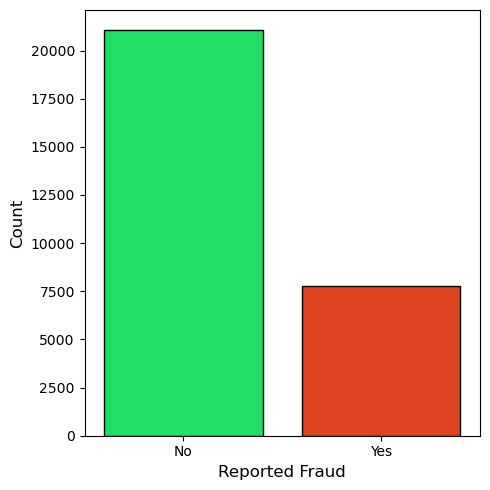

In [104]:
plt.figure(figsize = (5,5))
palette_green_red = ['#00ff5d','#ff2d00']
sns.countplot(
    data = with_target_train_data, 
    x = 'ReportedFraud',
    palette=sns.color_palette(palette_green_red, 2),
    edgecolor = 'black'
)
plt.gca().tick_params(which = 'major', labelsize = 10)
plt.xlabel("Reported Fraud", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.tight_layout()
plt.savefig(path + r"\Insurance_Data\Figures\FraudOverview.png")

In [131]:
feature_vector = pd.merge(policy, claim_train_data_copy, on =  "CustomerID")
feature_vector = pd.merge(feature_vector, demographics, on =  "CustomerID")
feature_vector = pd.merge(feature_vector, with_target_train_data, on =  "CustomerID")

In [132]:
#feature_vector['ReportedFraud'] = feature_vector['ReportedFraud'].map({'Yes':1,'No':0})
feature_vector = feature_vector.drop(['CustomerID'], axis=1)

In [133]:
feature_vector.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 0 to 9680
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerLoyaltyPeriod  9681 non-null   int64  
 1   InsurancePolicyState   9681 non-null   int64  
 2   Policy_Deductible      9681 non-null   int64  
 3   PolicyAnnualPremium    9681 non-null   float64
 4   UmbrellaLimit          9681 non-null   int64  
 5   InsuredRelationship    9681 non-null   int64  
 6   TypeOfIncident         9681 non-null   int64  
 7   TypeOfCollission       9681 non-null   int64  
 8   SeverityOfIncident     9681 non-null   int64  
 9   AuthoritiesContacted   9681 non-null   int64  
 10  IncidentState          9681 non-null   int64  
 11  IncidentCity           9681 non-null   int64  
 12  IncidentAddress        9681 non-null   int64  
 13  IncidentTime           9681 non-null   int64  
 14  NumberOfVehicles       9681 non-null   int64  
 15  Prop

### Scaling  Data

In [134]:
feature_vector = feature_vector.dropna()

true_labels = feature_vector['ReportedFraud']
feature_vector = feature_vector.drop(['ReportedFraud'], axis=1)

#Scaling
scaler = StandardScaler()
scaler.fit(feature_vector)
scaled_feature_vector = pd.DataFrame(scaler.transform(feature_vector),columns= feature_vector.columns )

# Split test and train 
X_train, X_test, y_train, y_test = train_test_split(scaled_feature_vector, true_labels, test_size=0.2, random_state=33)

### Training Model 

#### Logistic Regression 

In [24]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train,y_train)

NameError: name 'X_train' is not defined

In [25]:
predictions =logisticRegr.predict(X_test)

NameError: name 'X_test' is not defined

C:\Users\shrab\miniconda3\envs\PhDenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


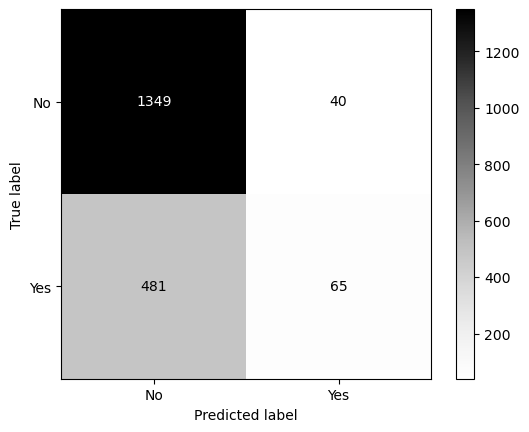

In [192]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logisticRegr, X_test, y_test, cmap = 'Greys')  
plt.savefig(path + r"\Insurance_Data\Figures\LogisticReg_ConfusionMatrix.png")

#### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier(max_depth=1000, random_state=0)
randomForest.fit(X_train,y_train)
predictions =randomForest.predict(X_test)

NameError: name 'X_train' is not defined

In [27]:
plot_confusion_matrix(randomForest, X_test, y_test, cmap = 'Greys')  
plt.savefig(path + r"\Insurance_Data\Figures\RandomForest_ConfusionMatrix.png")

NameError: name 'plot_confusion_matrix' is not defined

### Draft Section 

In [109]:
scaled_feature_vector.head()

,CustomerLoyaltyPeriod,InsurancePolicyState,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,...,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,DayOfIncident,MonthOfIncident,YearOfIncident,loss,InsuredAge,InsuredGender
0,1.191233,1.132572,-0.224614,0.591125,-0.469231,-1.464543,0.915324,-1.195918,0.007851,0.460371,...,0.650554,-0.653460,1.270028,0.718076,1.376290,-0.957296,0.0,1.417605,1.082856,-1.054967
1,0.474964,1.132572,-0.224614,0.345669,-0.469231,-0.897976,-1.028484,0.070726,0.007851,-0.450295,...,0.115130,-0.681848,-0.646725,0.636557,-1.725574,-0.957296,0.0,0.027078,-0.019569,0.947897
2,-1.803167,-1.246468,-1.130088,0.749806,-0.469231,-0.331410,0.915324,1.337370,1.194186,0.460371,...,-2.479999,-1.715188,-1.702245,-2.330735,2.050608,-0.957296,0.0,0.027078,-0.754519,0.947897
3,2.375065,1.132572,1.586335,-0.595250,-0.469231,0.801723,-1.028484,1.337370,0.007851,-0.450295,...,3.738330,2.517532,2.621325,3.518254,0.027653,0.953147,0.0,-1.303444,2.675249,0.947897
4,-1.474877,1.132572,-1.130088,-0.251323,1.195418,0.235156,0.915324,0.070726,1.194186,1.371037,...,-0.425284,-1.164452,0.226108,-0.269323,0.971699,-0.957296,0.0,0.027078,-1.979436,-1.054967


In [136]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_feature_vector)
PCA_ds = pd.DataFrame(pca.transform(scaled_feature_vector), columns=(["col1","col2","col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,9671.0,4.729727e-17,1.746988,-6.582978,-1.158763,-0.124971,1.142506,6.970364
col2,9671.0,3.852661e-17,1.418277,-3.352405,-1.075434,-0.037916,0.943885,5.135295
col3,9671.0,-1.211361e-16,1.371766,-3.763535,-1.124147,0.054387,1.002298,5.620699


In [137]:
true_labels.unique()

array(['Yes', 'No'], dtype=object)

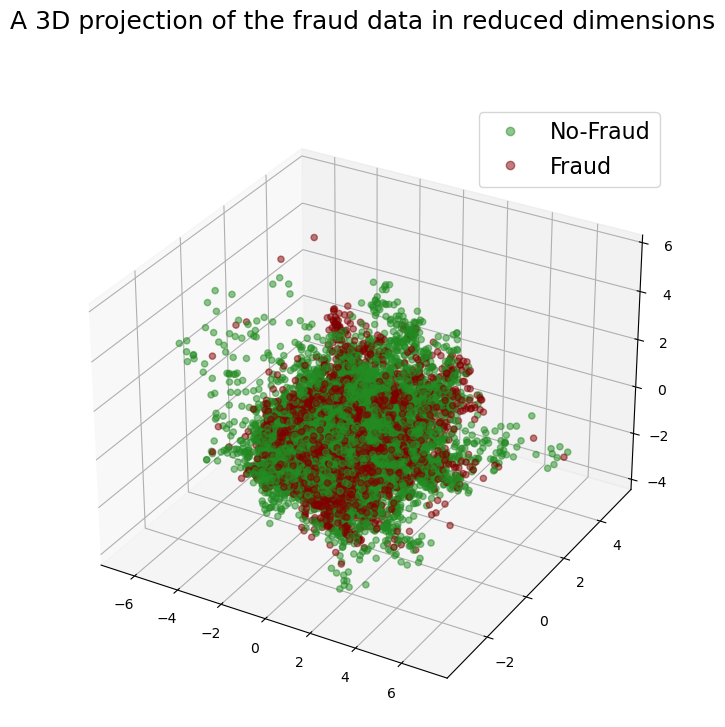

In [157]:
from matplotlib.lines import Line2D

PCA_ds["labels"] = true_labels
colors = {'Yes':'maroon', 'No':'forestgreen'}
color_list = true_labels.map(colors)


#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]


#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, c=color_list, alpha = 0.5)

ax.set_title("A 3D projection of the fraud data in reduced dimensions", fontsize = 18, y=1.2)
legend_elements = [Line2D([0], [0], color='forestgreen', ls = '',marker = 'o', mec = 'forestgreen', alpha = 0.5, label='No-Fraud'),
                   Line2D([0], [0], color='maroon', ls = '',marker = 'o', mec = 'maroon', alpha = 0.5, label='Fraud')]
plt.legend(handles = legend_elements, loc = "upper right", fontsize = 16)
plt.savefig(path + r"\Insurance_Data\Figures\PCA_data.png")
plt.show()

In [ ]:
# Quick examination of elbow method to find numbers of clusters to make.
from yellowbrick.cluster import KElbowVisualizer
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()



In [ ]:
sns.pairplot(feature_vector.sample(1000), hue = 'ReportedFraud')

### Preparing 

In [ ]:
# Labels are the values we want to predict
labels = np.array(feature_vector['ReportedFraud'])

# Remove the labels from the feature_vector
feature_vector= feature_vector.drop('ReportedFraud', axis = 1)

# Saving feature names for later use
feature_list = list(feature_vector.columns)

# Convert to numpy array
feature_vector = np.array(feature_vector)

In [ ]:
feature_vector

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(feature_vector, labels);

# Testing Data 

In [ ]:
### Draft Section 

In [ ]:
from sklearn.cluster import KMeans
X = np.array(merged.drop(['CustomerID'], axis=1))
  
kmeans = KMeans(n_clusters=2).fit(X)
labels = kmeans.labels_


In [ ]:
merged_target['Predictions'] = labels

In [ ]:
tn, fp, fn, tp = confusion_matrix(merged_target['ReportedFraudNumeric'], merged_target['Predictions']).ravel()

In [ ]:
print('False Positives ' + str(fp))
print('False Negatives ' + str(fn))
print('True Negatives ' + str(tn))
print('True Positives ' + str(tp))